# FAMIC Model Tutorial

This notebook demonstrates how to:
1. Load datasets from HuggingFace
2. Load tokenizers for text preprocessing
3. Initialize the FAMIC model architecture

## Setup

First, let's set up the environment and import necessary libraries.


In [1]:
# Add src to path
import sys
from pathlib import Path

# Get the project root directory (parent of notebooks)
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

print(f"Project root: {project_root}")
print(f"Python path updated")


Project root: E:\projects\FAMIC
Python path updated


In [2]:
# Import necessary libraries
import torch
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
from pathlib import Path

# Import FAMIC modules
from src.datasets import (
    load_dataset_csv,
    print_dataset_statistics,
    report_dataset_statistics,
    load_tokenizer,
    get_dataset_info,
    DATASET_REGISTRY
)

from src.model import (
    FAMIC,
    create_embedding_matrix,
    initialize_model_blocks,
    EMBEDDING_DIMENSIONS,
    VOCAB_LENGTH,
    MAX_LEN,
    NUM_HEADS
)

from src.download_weights import (
    download_all_weights,
    load_pretrained_weights,
    get_weights_path
)

print("✓ All imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")


c:\Projects\playground1\.venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


✓ All imports successful!
PyTorch version: 2.9.1+cu128
CUDA available: True
CUDA device: NVIDIA GeForce RTX 5090


### Clearing Cached Data

If you need to re-download datasets (e.g., after corrections on HuggingFace), you can clear the cache:


In [3]:
# Clear cached dataset to force re-download
# Uncomment the line below to clear cache for a specific dataset

from src.datasets import clear_dataset_cache, clear_all_cache

# Clear only the dataset cache
#clear_dataset_cache("twitter")

# Or clear both dataset and tokenizer cache
# clear_all_cache("twitter")

# Or clear everything including HuggingFace internal cache
# clear_all_cache("twitter", clear_hf_cache=True)

print("Cache clearing functions are available.")
print("Uncomment the lines above to clear cache when needed.")


Cache clearing functions are available.
Uncomment the lines above to clear cache when needed.


## HuggingFace Authentication

**Important**: If the repository is private or gated, you need to authenticate with HuggingFace first.

You have three options:

1. **Set environment variable** (recommended):
   ```python
   import os
   os.environ['HF_TOKEN'] = 'your_huggingface_token_here'
   ```

2. **Use the login function**:
   ```python
   from src.datasets import authenticate_huggingface
   authenticate_huggingface(token='your_huggingface_token_here')
   ```

3. **Use HuggingFace CLI** (before starting Jupyter):
   ```bash
   huggingface-cli login
   ```

Get your token from: https://huggingface.co/settings/tokens

**Note**: If you're not sure if authentication is needed, try loading the dataset first. The error message will tell you if authentication is required.


In [4]:
# Optional: Authenticate with HuggingFace if needed
# Uncomment and add your token if you get authentication errors

# Option 1: Set environment variable
# import os
# os.environ['HF_TOKEN'] = 'your_huggingface_token_here'

# Option 2: Use login function
# from src.datasets import authenticate_huggingface
# authenticate_huggingface(token='your_huggingface_token_here')

# Option 3: If you've already logged in via CLI, you can skip this cell
print("Authentication: If you get 401 errors, uncomment one of the options above")


Authentication: If you get 401 errors, uncomment one of the options above


## 1. Loading Datasets

The FAMIC model supports two datasets:
- **Twitter**: Twitter dataset cleaned in 2024
- **Wine**: Wine dataset with 140k samples cleaned in 2025

Both datasets are automatically downloaded from HuggingFace on first use and cached locally.


In [5]:
# Show available datasets
print("Available datasets:")
for name, info in DATASET_REGISTRY.items():
    print(f"  - {name}: {info['name']}")
    print(f"    Description: {info['description']}")
    print()


Available datasets:
  - twitter: Twitter Cleaned 2024
    Description: Twitter dataset cleaned in 2024

  - wine: Wine 140k Cleaned 2025
    Description: Wine dataset with 140k samples cleaned in 2025



In [6]:
# Choose which dataset to load
# Options: "twitter" or "wine"
DATASET_NAME = "wine"  # Change this to "wine" to load the wine dataset

print(f"Loading {DATASET_NAME} dataset...")
print("="*70)

# Load the dataset
df = load_dataset_csv(DATASET_NAME)

# Display basic information
print(f"\nDataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"\nFirst few rows:")
df.head()


Loading wine dataset...
Using cached dataset: data\datasets\wine_140k_cleaned2025.csv
Loading dataset from: data\datasets\wine_140k_cleaned2025.csv
✓ Dataset loaded: 141904 rows, 2 columns

Dataset shape: (141904, 2)
Columns: ['preprocessed_text', 'labels']

First few rows:


,preprocessed_text,labels
0,"tangy, zesty wild berry flavors have a refresh...",0
1,"ripe and focused, with an anise streak running...",0
2,"starts out rich, with peach, melon and apple f...",1
3,"firm in texture up front, with expressive blue...",1
4,"a big, broad-shouldered style, with dark espre...",1


In [7]:
# Get detailed dataset statistics
print_dataset_statistics(DATASET_NAME, df=df)



Dataset Statistics: Wine 140k Cleaned 2025
Description: Wine dataset with 140k samples cleaned in 2025
Total Rows: 141,904
Total Columns: 2
Shape: 141,904 rows × 2 columns
Memory Usage: 34.04 MB
Duplicate Rows: 1

Column Names:
   1. preprocessed_text              (object         ) - Missing: 0 (0.00%)
   2. labels                         (int64          ) - Missing: 0 (0.00%)

⚠ Warning: 1 duplicate rows found



## 2. Loading Tokenizers

Each dataset has its own tokenizer that was used during training. The tokenizers are also downloaded from HuggingFace.


In [8]:
# Load the tokenizer for the selected dataset
print(f"Loading tokenizer for '{DATASET_NAME}' dataset...")
print("="*70)

tokenizer = load_tokenizer(DATASET_NAME)

# Display tokenizer information
print(f"\nTokenizer loaded successfully!")
print(f"Vocabulary size: {len(tokenizer.word_index) if hasattr(tokenizer, 'word_index') else 'N/A'}")
print(f"OOV token: {tokenizer.oov_token if hasattr(tokenizer, 'oov_token') else 'N/A'}")


Loading tokenizer for 'wine' dataset...
  Repository: ycy198888/jds_support_files
  Repository type: dataset
  File path: tokenizers/wine_famic_tokenizer.json


c:\Projects\playground1\.venv\Lib\site-packages\huggingface_hub\file_download.py:979: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(


✓ Tokenizer downloaded to: data\tokenizers\tokenizers\wine_famic_tokenizer.json
Loading tokenizer from: data\tokenizers\tokenizers\wine_famic_tokenizer.json
✓ Tokenizer loaded successfully

Tokenizer loaded successfully!
Vocabulary size: 244799
OOV token: [OOV]


In [9]:
# Example: Tokenize some sample text
if hasattr(df, 'columns'):
    # Try to find a text column (common names)
    text_columns = [col for col in df.columns if any(keyword in col.lower() 
                   for keyword in ['text', 'review', 'comment', 'content', 'tweet'])]
    
    if text_columns:
        sample_text = df[text_columns[0]].iloc[0] if len(df) > 0 else "This is a sample text."
        print(f"Sample text: {sample_text}")
        print(f"\nTokenizing sample text...")
        
        # Tokenize
        sequences = tokenizer.texts_to_sequences([sample_text])
        print(f"Tokenized sequence: {sequences[0]}")
        print(f"Sequence length: {len(sequences[0])}")
    else:
        print("No text column found. Please adjust the column name in the code above.")
        print(f"Available columns: {list(df.columns)}")
else:
    print("DataFrame not available")


Sample text: tangy, zesty wild berry flavors have a refreshing herbal side, with a hint of orange peel. good intensity and balance, with gingerbread and cigar spices on the finish. drink now through 2012. 50 cases made.

Tokenizing sample text...
Tokenized sequence: [34786, 129593, 2215, 4022, 11626, 16, 6, 3857, 13403, 646, 25, 6, 3424, 15, 1676, 8893, 32, 19184, 10, 4256, 25, 28196, 10, 11777, 21656, 18, 4, 599, 610, 31, 394, 10781, 1072, 4994, 205]
Sequence length: 35


## 3. Initializing the FAMIC Model

Now we'll initialize the FAMIC model architecture. The model requires:
- An embedding matrix (can be empty or pre-trained)
- Model hyperparameters

### 3.1 Create Embedding Matrix

First, we create an embedding matrix. For now, we'll create an empty one that can be filled with pre-trained embeddings later.


In [10]:
# Create embedding matrix
# In practice, you would load pre-trained embeddings (e.g., Word2Vec, GloVe)
# For now, we create an empty matrix that matches the expected dimensions

embedding_dim = EMBEDDING_DIMENSIONS  # 300
vocab_length = VOCAB_LENGTH  # 250000

print(f"Creating embedding matrix...")
print(f"  Vocabulary size: {vocab_length + 1}")
print(f"  Embedding dimension: {embedding_dim}")

embedding_matrix = create_embedding_matrix(
    vocab_length=vocab_length,
    embedding_dim=embedding_dim
)

print(f"\n✓ Embedding matrix created")
print(f"  Shape: {embedding_matrix.shape}")
print(f"  Dtype: {embedding_matrix.dtype}")


Creating embedding matrix...
  Vocabulary size: 250001
  Embedding dimension: 300

✓ Embedding matrix created
  Shape: torch.Size([250001, 300])
  Dtype: torch.float32


### 3.2 Initialize Model Blocks

We can initialize individual model blocks or the complete FAMIC model.


In [11]:
# Initialize individual model blocks
print("Initializing FAMIC model blocks...")
print("="*70)

blocks = initialize_model_blocks(
    embedding_matrix=embedding_matrix,
    hidden_dim=EMBEDDING_DIMENSIONS,
    n_layers=2,
    max_relative_position_mask=2,
    max_relative_position_shift=3,
    pivot=0.5,
    num_heads=NUM_HEADS,
    drop_prob=0.5,
    digits_dim=1
)

print("\n✓ Model blocks initialized:")
for block_name in blocks.keys():
    print(f"  - {block_name}: {type(blocks[block_name]).__name__}")


Initializing FAMIC model blocks...

✓ Model blocks initialized:
  - embeds: Embeds
  - sentiment: Sentiment_block
  - mask: Mask_block
  - shifter1: Shifter_block1
  - shifter2: Shifter_block2
  - synthesizer: Synthesizer


In [ ]:
# Initialize the complete FAMIC model
print("Initializing complete FAMIC model...")
print("="*70)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = FAMIC(
    embedding_matrix=embedding_matrix,
    hidden_dim=EMBEDDING_DIMENSIONS,
    n_layers=2,
    max_relative_position_mask=2,
    max_relative_position_shift=3,
    pivot=0.5,
    num_heads=NUM_HEADS,
    drop_prob=0.5,
    digits_dim=1
)

model = model.to(device)
model.eval()  # Set to evaluation mode

print("\n✓ FAMIC model initialized successfully!")
print(f"  Model device: {next(model.parameters()).device}")


Initializing complete FAMIC model...
Using device: cuda

✓ FAMIC model initialized successfully!
  Model device: cuda:0
  Model parameters: 76,896,669
  Trainable parameters: 76,896,669


### 3.3 Load Pretrained Weights from HuggingFace

Now we can load pretrained weights for the selected dataset. The weights are automatically downloaded from HuggingFace if not already cached.


In [13]:
# Load pretrained weights from HuggingFace
# This will automatically download weights if not already cached
print("Loading pretrained weights from HuggingFace...")
print("="*70)

from src.download_weights import load_pretrained_weights

# Load weights into the model blocks
model_blocks_loaded = load_pretrained_weights(
    model_blocks={
        'embeds': model.embeds,
        'sentiment': model.sentiment,
        'mask': model.mask,
        'shifter1': model.shifter1,
        'shifter2': model.shifter2,
        'synthesizer': model.synthesizer
    },
    dataset_name=DATASET_NAME,
    cache_dir="models",
    version="v2",  # Model version
    device=device
)

print("\n✓ Pretrained weights loaded successfully!")
print(f"  Model is ready for inference on '{DATASET_NAME}' dataset")


Loading pretrained weights from HuggingFace...
Loading pretrained weights for 'wine' dataset...
  Device: cuda
  Repository: ycy198888/jds_support_files
  Repository type: dataset
  File path: FAMIC/wine_pretrained_weights/embedding_weights.pt
✓ Weight downloaded to: models\wine\FAMIC\wine_pretrained_weights\embedding_weights.pt
  Repository: ycy198888/jds_support_files
  Repository type: dataset
  File path: FAMIC/wine_pretrained_weights/three_block_mb1_v2.pt
✓ Weight downloaded to: models\wine\FAMIC\wine_pretrained_weights\three_block_mb1_v2.pt
  Repository: ycy198888/jds_support_files
  Repository type: dataset
  File path: FAMIC/wine_pretrained_weights/three_block_mb2_v2.pt
✓ Weight downloaded to: models\wine\FAMIC\wine_pretrained_weights\three_block_mb2_v2.pt
  Repository: ycy198888/jds_support_files
  Repository type: dataset
  File path: FAMIC/wine_pretrained_weights/three_block_mb31_v2.pt
✓ Weight downloaded to: models\wine\FAMIC\wine_pretrained_weights\three_block_mb31_v2.pt
 

**Alternative: Initialize model with pretrained weights directly**

You can also create a model and load weights in one step:


In [ ]:
# Alternative: Create model with pretrained weights in one step
print("Alternative method: Loading model with pretrained weights...")
print("="*70)

# Create a new model instance with pretrained weights
model_pretrained = FAMIC.from_pretrained_huggingface(
    dataset_name=DATASET_NAME,
    embedding_matrix=embedding_matrix,
    cache_dir="models",
    version="v2",
    device=device,
    hidden_dim=EMBEDDING_DIMENSIONS,
    n_layers=2,
    max_relative_position_mask=2,
    max_relative_position_shift=3,
    pivot=0.5,
    num_heads=NUM_HEADS,
    drop_prob=0.5,
    digits_dim=1
)

print("\n✓ Model with pretrained weights created successfully!")
print(f"  Model device: {next(model_pretrained.parameters()).device}")


Alternative method: Loading model with pretrained weights...
Loading pretrained weights for 'wine' dataset...
  Device: cuda
  Repository: ycy198888/jds_support_files
  Repository type: dataset
  File path: FAMIC/wine_pretrained_weights/embedding_weights.pt
✓ Weight downloaded to: models\wine\FAMIC\wine_pretrained_weights\embedding_weights.pt
  Repository: ycy198888/jds_support_files
  Repository type: dataset
  File path: FAMIC/wine_pretrained_weights/three_block_mb1_v2.pt
✓ Weight downloaded to: models\wine\FAMIC\wine_pretrained_weights\three_block_mb1_v2.pt
  Repository: ycy198888/jds_support_files
  Repository type: dataset
  File path: FAMIC/wine_pretrained_weights/three_block_mb2_v2.pt
✓ Weight downloaded to: models\wine\FAMIC\wine_pretrained_weights\three_block_mb2_v2.pt
  Repository: ycy198888/jds_support_files
  Repository type: dataset
  File path: FAMIC/wine_pretrained_weights/three_block_mb31_v2.pt
✓ Weight downloaded to: models\wine\FAMIC\wine_pretrained_weights\three_bloc

### 3.4 Test Model Forward Pass

Let's test the model with some dummy input to verify everything works.


## 4. Creating Train/Validation/Test Splits

For evaluation, we need to split the dataset into train, validation, and test sets. The model is trained on the training set, early stopped using the validation set, and finally evaluated on the test set.


**Note**: If you get an `ImportError` for `WordDataset`, restart your kernel or run the cell below to reload the module.


In [15]:
# Force reload the datasets module to pick up new classes
import importlib
import sys

# Remove the module from cache if it exists
if 'src.datasets' in sys.modules:
    del sys.modules['src.datasets']

# Re-import
from src.datasets import (
    WordDataset,
    create_train_val_test_split,
    create_dataloaders,
    load_dataset_csv,
    load_tokenizer
)

print("✓ Module reloaded successfully")
print("✓ WordDataset and other functions are now available")


✓ Module reloaded successfully
✓ WordDataset and other functions are now available


In [16]:
# Create train/validation/test splits and dataloaders
from src.datasets import create_dataloaders, create_train_val_test_split

# Configuration
MAX_LEN = 150  # Maximum sequence length
BATCH_SIZE = 100  # Batch size for training/evaluation
SEED = 2025  # Random seed for reproducibility

# Column names (adjust these based on your dataset structure)
# Common names: 'text', 'preprocessed_text', 'review', 'tweet', etc.
TEXT_COLUMN = "preprocessed_text"  # Adjust if your dataset uses a different column name
LABEL_COLUMN = "labels"  # Adjust if your dataset uses a different column name

print(f"Creating dataloaders for '{DATASET_NAME}' dataset...")
print("="*70)

# Create dataloaders
train_loader, val_loader, test_loader = create_dataloaders(
    dataset_name=DATASET_NAME,
    text_column=TEXT_COLUMN,
    label_column=LABEL_COLUMN,
    max_len=MAX_LEN,
    batch_size=BATCH_SIZE,
    test_size=0.1,  # 10% for test
    val_size=0.5,   # 50% of test set for validation (so 5% total)
    random_state=SEED,
    num_workers=0
)


Creating dataloaders for 'wine' dataset...
Using cached dataset: data\datasets\wine_140k_cleaned2025.csv
Loading dataset from: data\datasets\wine_140k_cleaned2025.csv
✓ Dataset loaded: 141904 rows, 2 columns
Data Split done.
train/val/test: 127713 / 7095 / 7096
train label mean: 0.3418, val: 0.3446, test: 0.3430
  Repository: ycy198888/jds_support_files
  Repository type: dataset
  File path: tokenizers/wine_famic_tokenizer.json


c:\Projects\playground1\.venv\Lib\site-packages\huggingface_hub\file_download.py:979: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(


✓ Tokenizer downloaded to: data\tokenizers\tokenizers\wine_famic_tokenizer.json
Loading tokenizer from: data\tokenizers\tokenizers\wine_famic_tokenizer.json
✓ Tokenizer loaded successfully

✓ DataLoaders created:
  Train batches: 1278
  Val batches: 71
  Test batches: 71


In [17]:
# Verify the dataloaders work
print("\nTesting dataloaders...")
print("="*70)

# Get a sample batch from train loader
sample_batch = next(iter(train_loader))
print(f"\nSample batch from train loader:")
print(f"  word_ids shape: {sample_batch['word_ids'].shape}")
print(f"  attention_mask shape: {sample_batch['attention_mask'].shape}")
print(f"  labels shape: {sample_batch['labels'].shape}")
print(f"  Batch size: {sample_batch['word_ids'].shape[0]}")
print(f"  Sequence length: {sample_batch['word_ids'].shape[1]}")

# Show a sample
print(f"\nSample from batch:")
print(f"  First word_ids (first 20 tokens): {sample_batch['word_ids'][0][:20].tolist()}")
print(f"  First attention_mask (first 20): {sample_batch['attention_mask'][0][:20].tolist()}")
print(f"  First label: {sample_batch['labels'][0].item()}")



Testing dataloaders...

Sample batch from train loader:
  word_ids shape: torch.Size([100, 150])
  attention_mask shape: torch.Size([100, 150])
  labels shape: torch.Size([100])
  Batch size: 100
  Sequence length: 150

Sample from batch:
  First word_ids (first 20 tokens): [1, 59682, 7236, 362, 2812, 12970, 10, 455, 15, 2714, 6647, 30, 22958, 1240, 11626, 15, 14535, 707, 7409, 61096]
  First attention_mask (first 20): [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
  First label: 1.0


## 5. Evaluating the Model

Now that we have the model, pretrained weights, and test dataloader, we can evaluate the model performance on the test set.


In [18]:
# Evaluate the model on test set
from src.evaluate import evaluate_model, eval_val_loss
import torch.nn as nn

# Set evaluation flags (these should match how the model was trained)
USE_MASK = True
USE_SHIFT1 = True
USE_SHIFT2 = True

# Use the model with pretrained weights (model_pretrained from earlier)
# Or use the model after loading weights (model from earlier)
# Check which model is available
if 'model_pretrained' in globals():
    eval_model = model_pretrained
    print("Using model_pretrained (loaded with pretrained weights)")
elif 'model' in globals():
    eval_model = model
    print("Using model (make sure weights are loaded if needed)")
else:
    raise NameError("Neither 'model' nor 'model_pretrained' is defined. Please run the model initialization cells first.")

print("Evaluating model on test set...")
print("="*70)

# Define loss function (BCEWithLogitsLoss for binary classification)
criterion = nn.BCEWithLogitsLoss()

# Evaluate on test set
test_metrics = evaluate_model(
    model=eval_model,  # Use the available model
    dataloader=test_loader,
    device=device,
    criterion=criterion,
    use_mask=USE_MASK,
    use_shift1=USE_SHIFT1,
    use_shift2=USE_SHIFT2,
    return_loss=True
)

print("\n✓ Evaluation complete!")
print(f"Test Accuracy: {test_metrics['accuracy']:.4f}")
print(f"Test F1-Score: {test_metrics['f1_score']:.4f}")


Evaluating model on test set...

EVALUATION RESULTS
Accuracy:  0.8892 | Precision: 0.8486 | Recall: 0.8242 | F1: 0.8362
Average Loss: 0.2649
Average Mask Value: 1.0000

Confusion Matrix: TP=2006, FP=358, TN=4304, FN=428
Confusion Matrix:
[[4304  358]
 [ 428 2006]]


✓ Evaluation complete!
Test Accuracy: 0.8892
Test F1-Score: 0.8362


In [19]:
# Alternative: Use eval_val_loss for compatibility with original code
print("Using eval_val_loss function (original signature)...")
print("="*70)

val_loss, val_acc = eval_val_loss(
    model=eval_model,
    data_loader=test_loader,
    device=device,
    criterion=criterion,
    use_mask=USE_MASK,
    use_shift1=USE_SHIFT1,
    use_shift2=USE_SHIFT2
)

print(f"\nValidation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")


Using eval_val_loss function (original signature)...

EVALUATION RESULTS
Accuracy:  0.8892 | Precision: 0.8486 | Recall: 0.8242 | F1: 0.8362
Average Loss: 0.2649
Average Mask Value: 1.0000

Confusion Matrix: TP=2006, FP=358, TN=4304, FN=428
Confusion Matrix:
[[4304  358]
 [ 428 2006]]


Validation Loss: 0.2649
Validation Accuracy: 0.8892


### 5.1 Detailed Evaluation Metrics

Let's examine the detailed evaluation results:


In [ ]:
# Display detailed evaluation metrics
print("="*70)
print("DETAILED EVALUATION METRICS")
print("="*70)
print(f"\nDataset: {DATASET_NAME}")
print(f"Evaluation Configuration:")
print(f"  Use Mask: {USE_MASK}")
print(f"  Use Shifter 1: {USE_SHIFT1}")
print(f"  Use Shifter 2: {USE_SHIFT2}")
print(f"\nPerformance Metrics:")
print(f"  Accuracy:  {test_metrics['accuracy']:.4f}")
print(f"  Precision: {test_metrics['precision']:.4f}")
print(f"  Recall:    {test_metrics['recall']:.4f}")
print(f"  F1-Score:  {test_metrics['f1_score']:.4f}")
if 'loss' in test_metrics:
    print(f"  Loss:      {test_metrics['loss']:.4f}")

print(f"\nConfusion Matrix Breakdown:")
print(f"  True Positives (TP):  {test_metrics['TP']}")
print(f"  True Negatives (TN):  {test_metrics['TN']}")
print(f"  False Positives (FP): {test_metrics['FP']}")
print(f"  False Negatives (FN): {test_metrics['FN']}")
print("="*70)


DETAILED EVALUATION METRICS

Dataset: wine
Evaluation Configuration:
  Use Mask: True
  Use Shifter 1: True
  Use Shifter 2: True

Performance Metrics:
  Accuracy:  0.8892
  Precision: 0.8486
  Recall:    0.8242
  F1-Score:  0.8362
  Loss:      0.2649
  Avg Mask:  1.0000

Confusion Matrix Breakdown:
  True Positives (TP):  2006
  True Negatives (TN):  4304
  False Positives (FP): 358
  False Negatives (FN): 428


In [21]:
# Generate classification report
from sklearn.metrics import classification_report

# Get predictions and true labels from the metrics
# Note: We need to reconstruct these from the confusion matrix or re-run evaluation
# For now, let's create a simple report based on the confusion matrix

print("Classification Report:")
print("="*70)

# Calculate per-class metrics from confusion matrix
cm = test_metrics['confusion_matrix']
TN, FP, FN, TP = cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]

# Calculate per-class precision, recall, F1
precision_class0 = TN / (TN + FN + 1e-12)  # Precision for class 0
recall_class0 = TN / (TN + FP + 1e-12)     # Recall for class 0
f1_class0 = 2 * precision_class0 * recall_class0 / (precision_class0 + recall_class0 + 1e-12)

precision_class1 = TP / (TP + FP + 1e-12)  # Precision for class 1
recall_class1 = TP / (TP + FN + 1e-12)     # Recall for class 1
f1_class1 = 2 * precision_class1 * recall_class1 / (precision_class1 + recall_class1 + 1e-12)

print(f"\nClass 0 (Negative):")
print(f"  Precision: {precision_class0:.4f}")
print(f"  Recall:    {recall_class0:.4f}")
print(f"  F1-Score:  {f1_class0:.4f}")
print(f"  Support:   {TN + FP}")

print(f"\nClass 1 (Positive):")
print(f"  Precision: {precision_class1:.4f}")
print(f"  Recall:    {recall_class1:.4f}")
print(f"  F1-Score:  {f1_class1:.4f}")
print(f"  Support:   {TP + FN}")

print(f"\nOverall:")
print(f"  Accuracy:  {test_metrics['accuracy']:.4f}")
print(f"  Total:     {TN + FP + TP + FN}")
print("="*70)


Classification Report:

Class 0 (Negative):
  Precision: 0.9096
  Recall:    0.9232
  F1-Score:  0.9163
  Support:   4662

Class 1 (Positive):
  Precision: 0.8486
  Recall:    0.8242
  F1-Score:  0.8362
  Support:   2434

Overall:
  Accuracy:  0.8892
  Total:     7096


### 5.2 Evaluation Summary

Summary of the evaluation results:


In [22]:
# Create a summary dictionary for easy access
evaluation_summary = {
    'dataset': DATASET_NAME,
    'configuration': {
        'use_mask': USE_MASK,
        'use_shift1': USE_SHIFT1,
        'use_shift2': USE_SHIFT2
    },
    'metrics': {
        'accuracy': test_metrics['accuracy'],
        'precision': test_metrics['precision'],
        'recall': test_metrics['recall'],
        'f1_score': test_metrics['f1_score']
    },
    'confusion_matrix': {
        'TP': test_metrics['TP'],
        'TN': test_metrics['TN'],
        'FP': test_metrics['FP'],
        'FN': test_metrics['FN']
    }
}

if 'loss' in test_metrics:
    evaluation_summary['metrics']['loss'] = test_metrics['loss']

print("Evaluation Summary:")
print("="*70)
print(f"Dataset: {evaluation_summary['dataset']}")
print(f"\nConfiguration:")
for key, value in evaluation_summary['configuration'].items():
    print(f"  {key}: {value}")
print(f"\nMetrics:")
for key, value in evaluation_summary['metrics'].items():
    print(f"  {key}: {value:.4f}")
print(f"\nConfusion Matrix:")
for key, value in evaluation_summary['confusion_matrix'].items():
    print(f"  {key}: {value}")
print("="*70)

# Store summary for later use
print("\n✓ Evaluation summary stored in 'evaluation_summary' variable")


Evaluation Summary:
Dataset: wine

Configuration:
  use_mask: True
  use_shift1: True
  use_shift2: True

Metrics:
  accuracy: 0.8892
  precision: 0.8486
  recall: 0.8242
  f1_score: 0.8362
  loss: 0.2649

Confusion Matrix:
  TP: 2006
  TN: 4304
  FP: 358
  FN: 428

✓ Evaluation summary stored in 'evaluation_summary' variable


Confusion matrix saved to results/test_confusion_matrix.png


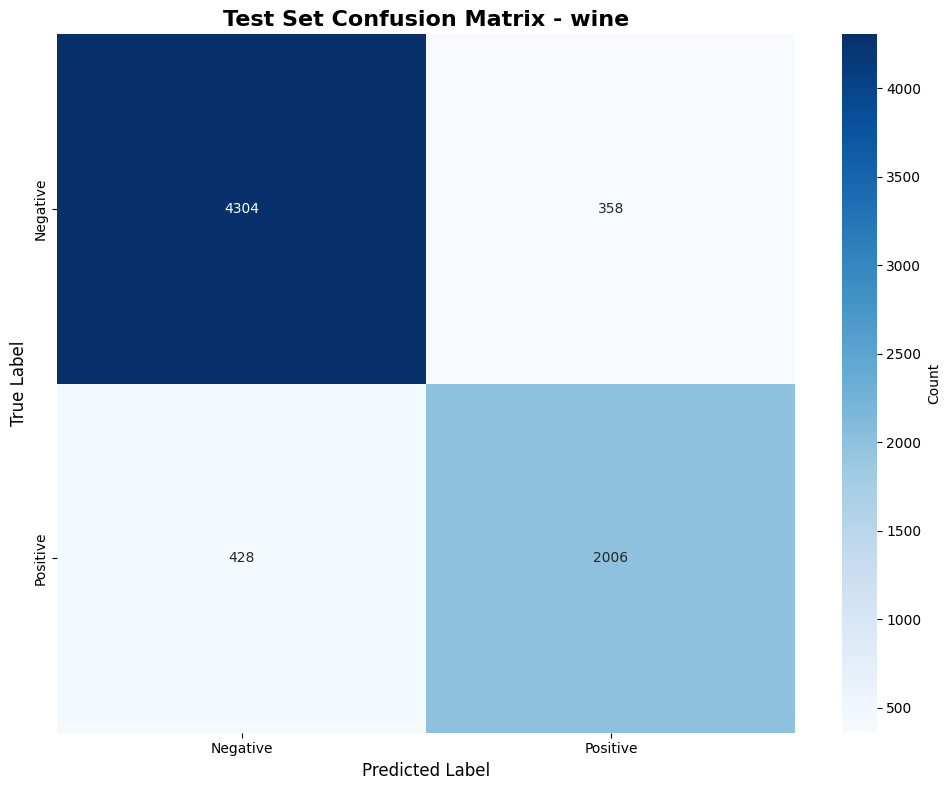

In [23]:
# Visualize confusion matrix
from src.evaluate import plot_confusion_matrix

plot_confusion_matrix(
    confusion_matrix=test_metrics['confusion_matrix'],
    class_names=["Negative", "Positive"],  # Adjust based on your dataset
    save_path="results/test_confusion_matrix.png",
    title=f"Test Set Confusion Matrix - {DATASET_NAME}"
)


## Summary

This notebook demonstrated:

1. ✅ **Loading datasets** from HuggingFace with automatic caching
2. ✅ **Loading tokenizers** for text preprocessing
3. ✅ **Initializing the FAMIC model** with all its components
4. ✅ **Loading pretrained weights** from HuggingFace for Twitter and Wine datasets
5. ✅ **Creating train/validation/test splits** with reproducible random seed (2025)
6. ✅ **Creating PyTorch DataLoaders** for model training and evaluation

### Next Steps

- Evaluate model performance on test set
- Generate classification reports
- Visualize results and confusion matrices
- Use the model for inference on new data

### Notes

- Datasets are cached in the `data/` directory after first download
- Tokenizers are cached in the `data/tokenizers/` directory
- Model weights are cached in the `models/{dataset_name}/` directory
- Data splits use random seed 2025 for reproducibility
- Default split: 90% train, 5% validation, 5% test
- Make sure to use the correct tokenizer and weights for each dataset
- Weights are automatically downloaded from HuggingFace on first use
